# Simple Audio Recongnition [link](https://www.tensorflow.org/tutorials/audio/simple_audio)

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print('GPU: ','available' if tf.config.list_physical_devices('GPU') else 'not avaiable') 

2023-02-22 23:57:10.866569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 23:57:11.806295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 23:57:11.806576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 23:57:11.806593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

GPU:  not avaiable


2023-02-22 23:57:12.653416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-22 23:57:12.653466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 8cb5a79a356d
2023-02-22 23:57:12.653479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 8cb5a79a356d
2023-02-22 23:57:12.653631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.86.1
2023-02-22 23:57:12.653663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-02-22 23:57:12.653674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.86.1


In [2]:
# dataset consists of 105,000 wav audio to classify words: ['yes' 'left' 'stop' 'up' 'right' 'no' 'go' 'down']
os.chdir('7-simple-audio-recognition-dataset')
url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

tf.keras.utils.get_file('mini_speech_commands.zip',
      origin=url,
      extract=True,
      cache_dir='.', cache_subdir='data')

'./data/mini_speech_commands.zip'

In [3]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
BATCH_SIZE = 64

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


2023-02-22 23:57:31.563442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [5]:
# removeing the last axis by squezing
def squeeze (audio, label):
    audio =tf.squeeze(audio, axis=-1) #remove the last axis
    return audio, label
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)



#sharding the data by (deviding the data to the number of workers starting of index with num_shards=2)
#but here we will take the half of the val_ds as a test_ds
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)



In [6]:
example_audio, example_labels = next(iter(train_ds.take(1)))
print(example_audio.shape)
print(example_labels.shape)

(64, 16000)
(64,)


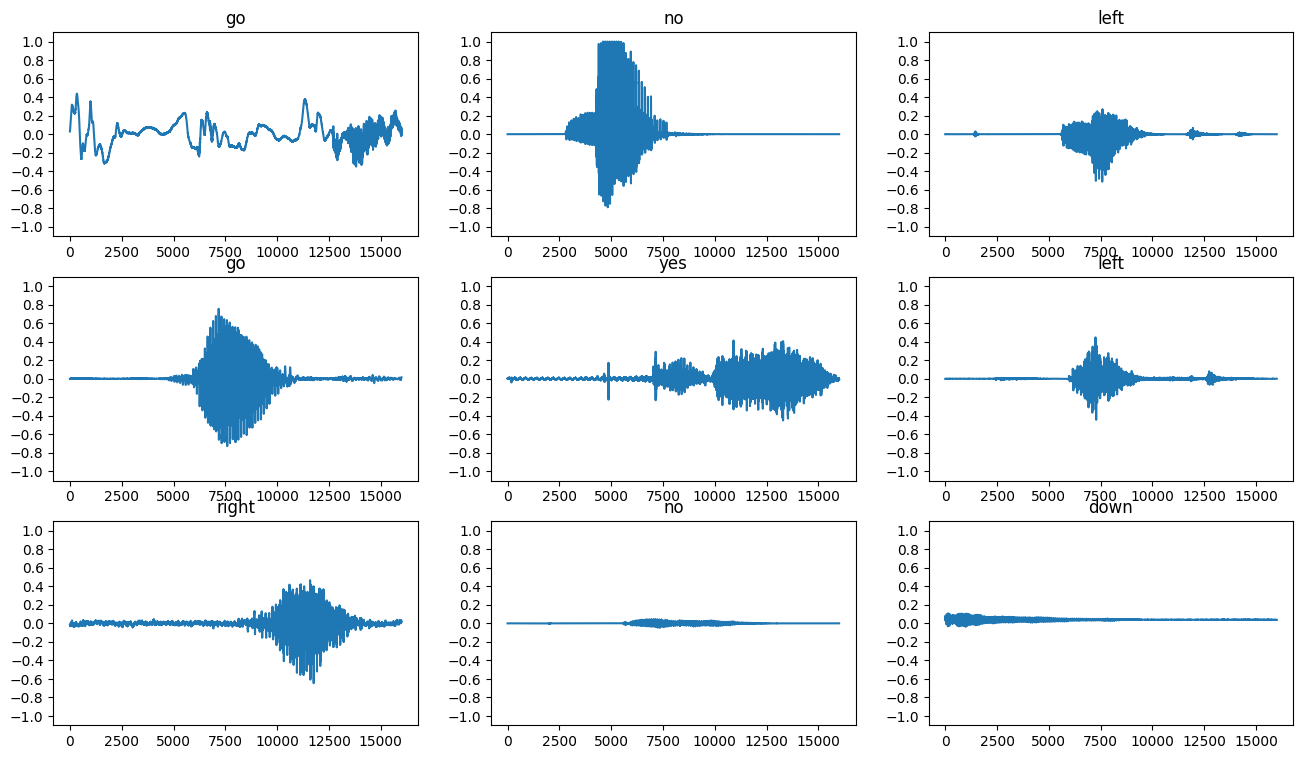

In [7]:
# plotting the audio files
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()


In [26]:
# applying stft to caputer both freq and time info
#input: (None, 160000), out(255, the rest)

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform,
                                 frame_length=255,
                                 frame_step=128) # hope size see this video: https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
     # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
                                 
                            
def map_get_spectogram(audio, label):
    return get_spectrogram(audio), label

#applying ther transromatoin
train_spectrogram_ds = train_ds.map(map_get_spectogram, num_parallel_calls=tf.data.AUTOTUNE)
val_spectrogram_ds = val_ds.map(map_get_spectogram, num_parallel_calls=tf.data.AUTOTUNE)
test_spectrogram_ds = test_ds.map(map_get_spectogram, num_parallel_calls=tf.data.AUTOTUNE)

print(next(iter(train_ds.take(1)))[0].shape)
print(next(iter(train_spectrogram_ds.take(1)))[0].shape) #batch x timeSamples x abs(fft) x 1
print(next(iter(train_spectrogram_ds.take(1)))[0][1][:1])


(64, 16000)
(64, 124, 129, 1)
tf.Tensor(
[[[1.95877627e-02]
  [2.78240591e-01]
  [7.71356583e-01]
  [6.84578121e-01]
  [2.30382800e-01]
  [2.34206975e-01]
  [2.92725980e-01]
  [3.67313772e-01]
  [4.90713954e-01]
  [4.15103674e-01]
  [3.07623297e-01]
  [2.29627833e-01]
  [1.40714690e-01]
  [9.06211585e-02]
  [6.59376830e-02]
  [9.07609537e-02]
  [8.56008381e-02]
  [3.82013954e-02]
  [5.98556288e-02]
  [1.62702739e-01]
  [1.58707798e-01]
  [1.13381311e-01]
  [1.48887470e-01]
  [2.15636417e-01]
  [2.06308097e-01]
  [2.47749805e-01]
  [3.62199605e-01]
  [6.03535593e-01]
  [5.88185489e-01]
  [4.15408283e-01]
  [8.12408328e-01]
  [7.53548443e-01]
  [6.49130225e-01]
  [7.33122230e-01]
  [6.03840470e-01]
  [4.29061294e-01]
  [3.58429313e-01]
  [2.38464147e-01]
  [2.49899894e-01]
  [2.90695995e-01]
  [6.86602741e-02]
  [1.46758109e-01]
  [1.33779064e-01]
  [1.34321466e-01]
  [1.00452736e-01]
  [9.17488635e-02]
  [1.33925647e-01]
  [5.02114408e-02]
  [6.79518655e-02]
  [6.18950464e-02]
  [2.4963

In [9]:
# Visualizing the data

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


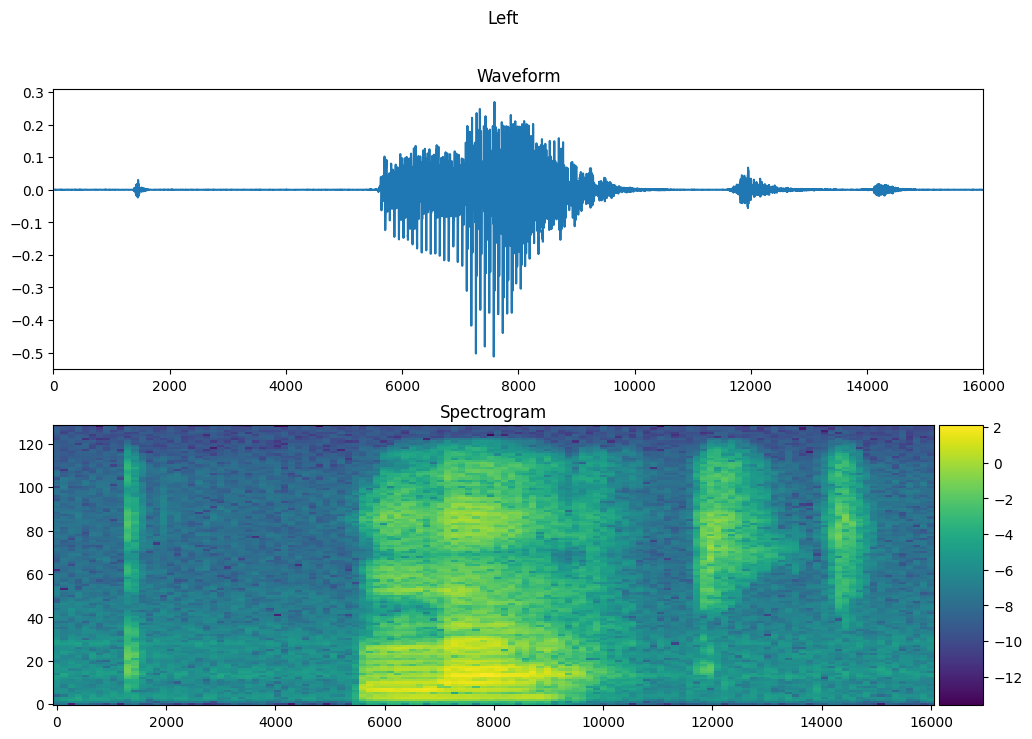

In [32]:
# visualising spcetrogram 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps) # adding small float number to avoid log(0) -> inf
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    im = ax.pcolormesh(X, Y, log_spec)

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

im = plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())


plt.show()
# spectrogram in LOG SCALE


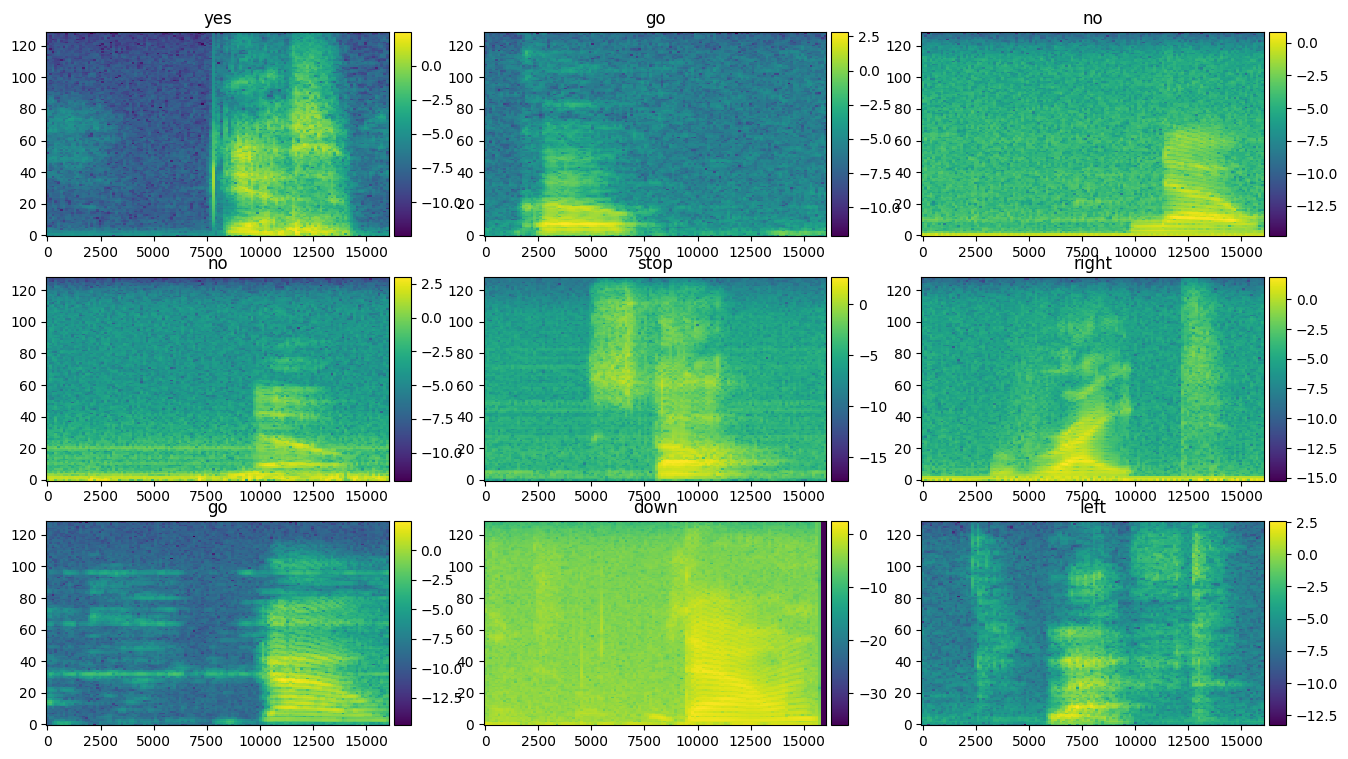

In [33]:
#more plots
example_spectrograms, example_spect_labels = next(iter(train_spectrogram_ds.take(1)))

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [34]:
# Budiling and Train the model

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [35]:
example_spectrograms, example_spect_labels = next(iter(train_spectrogram_ds.take(1)))
input_shape = example_spectrograms.shape[1:] # (124, 129, 1)  exculding batch

# normalizing layer
norm_layer = tf.keras.layers.Normalization()

# adapting the normalization
def get_spec(spec, label):
    return spec
norm_layer.adapt(data=train_spectrogram_ds.map(get_spec))

model = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # down sampling
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'), # 32 filters with size 3x3
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_names)),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 10s 94ms/step - loss: 1.6948 - accuracy: 0.4069 - val_loss: 1.2186 - val_accuracy: 0.6367
Epoch 2/10
100/100 [==============================] - 9s 86ms/step - loss: 1.1140 - accuracy: 0.6169 - val_loss: 0.8432 - val_accuracy: 0.7513
Epoch 3/10
100/100 [==============================] - 9s 88ms/step - loss: 0.8264 - accuracy: 0.7111 - val_loss: 0.7216 - val_accuracy: 0.7760
Epoch 4/10
100/100 [==============================] - 9s 91ms/step - loss: 0.6617 - accuracy: 0.7694 - val_loss: 0.6160 - val_accuracy: 0.7995
Epoch 5/10
100/100 [==============================] - 9s 89ms/step - loss: 0.5591 - accuracy: 0.8061 - val_loss: 0.5515 - val_accuracy: 0.8151
Epoch 6/10
100/100 [==============================] - 9s 93ms/step - loss: 0.4896 - accuracy: 0.8286 - val_loss: 0.5009 - val_accuracy: 0.8385
Epoch 7/10
100/100 [==============================] - 10s 99ms/step - loss: 0.4154 - accuracy: 0.8506 - val_loss: 0.4533 - val_accuracy: 0.86

In [38]:
# evalute the model
loss, accuracy = model.evaluate(test_spectrogram_ds, verbose=2)

13/13 - 1s - loss: 0.4464 - accuracy: 0.8570 - 516ms/epoch - 40ms/step


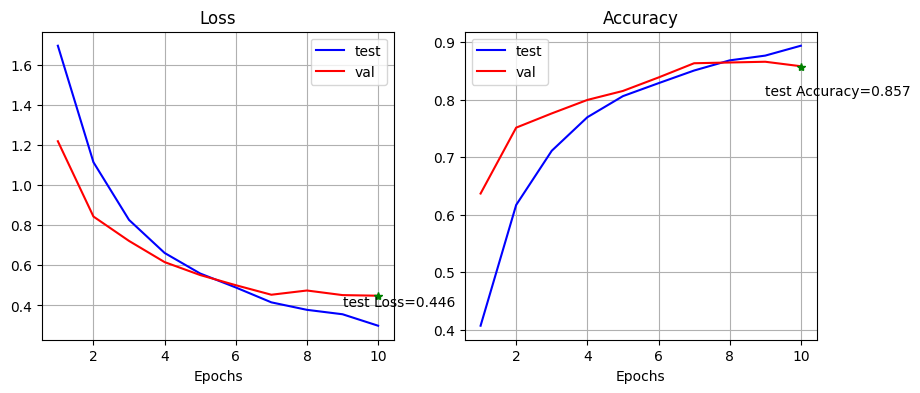

In [39]:
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    ax.annotate(f"test {title}={test_point:.3f}", xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_test_val(ax1, 'Loss', history.history['loss'], history.history['val_loss'], loss)
plot_test_val(ax2, 'Accuracy', history.history['accuracy'], history.history['val_accuracy'], accuracy)

plt.show()


13/13 [==============================] - 0s 15ms/step
(832, 8)
(832,)
(832,)


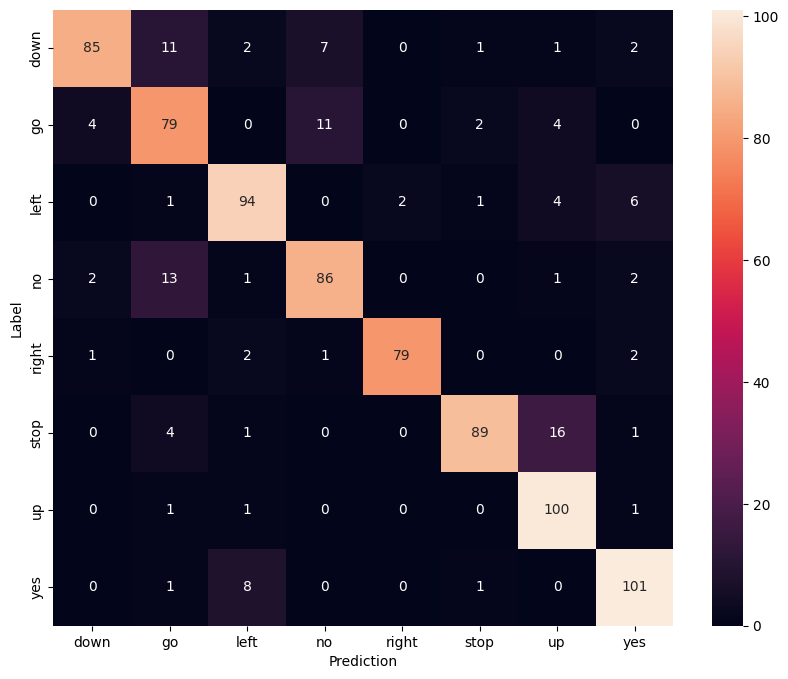

In [45]:
# display confusion matrix
y_pred = model.predict(test_spectrogram_ds)
print(y_pred.shape)
y_pred = tf.argmax(y_pred, axis=1) # get the max index 
print(y_pred.shape)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
print(y_true.shape)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


(124, 129, 1)
(1, 124, 129, 1)


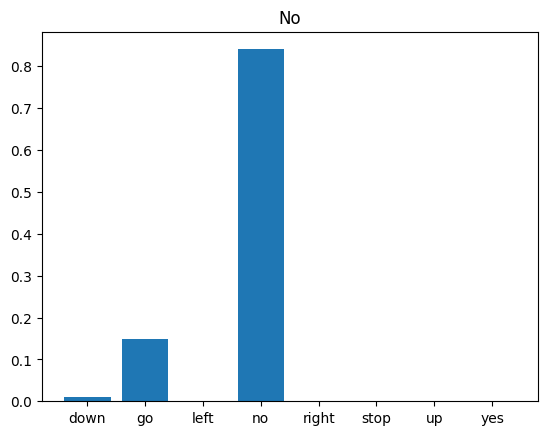

In [50]:
#Running the model

x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
print(x.shape)
x = x[tf.newaxis,...] # for batch size
print(x.shape)

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))


In [51]:
# exporting the model
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    result = tf.nn.softmax(result, axis=-1) # applying sofmax

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids) # return class name with id = class_ids
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}


In [52]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[9.4825057e-03, 1.4806136e-01, 6.7873352e-04, 8.4033906e-01,
         1.0878497e-04, 4.6316028e-04, 2.1413485e-04, 6.5225997e-04]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [53]:
#saving the model
tf.saved_model.save(export, "saved") # object, export direcoty
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[9.4825057e-03, 1.4806136e-01, 6.7873352e-04, 8.4033906e-01,
         1.0878497e-04, 4.6316028e-04, 2.1413485e-04, 6.5225997e-04]],
       dtype=float32)>}